In [150]:
import pandas as pd
import numpy as np
import itertools, csv

massWidth = 30 #GeV

1703 rows of qcd data
4605 rows of dihiggs data
Index(['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)'], dtype='object') deltaR(h1, h2)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe430b0ac18>]],
      dtype=object)

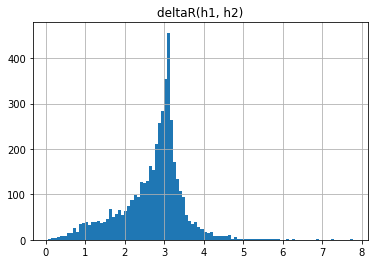

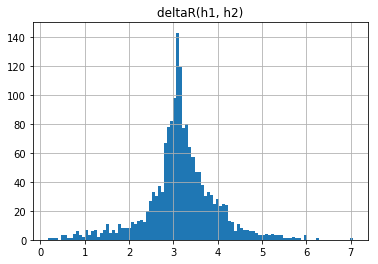

In [154]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../higgsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../higgsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

qcd_raw.head()
print(len(qcd_raw), "rows of qcd data")
hh_raw.head()
print(len(hh_raw), "rows of dihiggs data")
#print(hh_raw.columns)

#variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

hh_reducedData  = hh_raw[variableNames]
qcd_reducedData = qcd_raw[variableNames]
print(hh_reducedData.columns, variableNames[0])
hh_reducedData.hist(column=variableNames[0], bins=100)
qcd_reducedData.hist(column=variableNames[0], bins=100)


In [148]:
def returnBestCutValue( _variable, _signal, _background, _method='S/B'):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = massWidth #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    
    _minVal = int(min(min(sortedBackground), min(sortedSignal))) if 'mass' not in _variable else int(min(min(sortedBackground), min(sortedSignal))) - int(min(min(sortedBackground), min(sortedSignal)))%5
    _maxVal = int(max(max(sortedBackground), max(sortedSignal))) if 'mass' not in _variable else int(max(max(sortedBackground), max(sortedSignal))) - int(max(max(sortedBackground), max(sortedSignal)))%5
    _stepSize = 0.05 if 'mass' not in _variable else 5
    _cuts = list(range(_minVal, _maxVal, _stepSize))
    
    for iCutValue in _cuts:
        if 'mass' in _variable:
            _nSignal = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _signal) 
            _nBackground = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _background)
        else:
            _nSignal = sum( value < iCutValue for value in _signal)
            _nBackground = sum( value < iCutValue for value in _background)

        # temporary fix since samples with different number of events
        _nSignal = _nSignal / _nTotalSignal
        _nBackground = _nBackground / _nTotalBackground
        
        # safety check to avoid division by 0
        if _nBackground == 0:
            continue
        
        #if _method == 'S/sqrt(S+B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
        
    return _bestSignificance, _bestCutValue


def returnSignificanceOrderedCutDict( _method, _varNames, _signalDataFrame, _backgroundDataFrame):
    """function to return list of cuts ordered by descending significance"""
    
    _orderedVariableAndCutDict = {}
    _unprocessedVariables = _varNames
    _signalAfterCuts = _signalDataFrame
    _backgroundAfterCuts = _backgroundDataFrame
    
    while len(_unprocessedVariables)>0:
        _iBestCut = -1
        _iBestSignificance = -1
        _iBestVariable = ''
        print('iteration {0}, signal has {1} rows'.format(len(_unprocessedVariables), len(_signalAfterCuts)))
        print('iteration {0}, background has {1} rows'.format(len(_unprocessedVariables), len(_backgroundAfterCuts)))
        
        for iVariable in _unprocessedVariables:
            _sortedSignal = np.sort(_signalDataFrame[iVariable].values)
            _sortedBackground = np.sort(_backgroundDataFrame[iVariable].values)
            #print(_sortedSignal)
            _tempSignificance, _tempCut = returnBestCutValue( iVariable, _sortedSignal, _sortedBackground, _method)
            #print ( iVariable, _tempSignificance, _tempCut )
                
            # most significant 1D variable so far in this iteration
            if _tempSignificance > _iBestSignificance:
                _iBestSignificance = _tempSignificance
                _iBestCut = _tempCut
                _iBestVariable = iVariable
        
        print('Iteration {0} chose variable {1} with significance {2} at cut {3}'.format(int(len(_varNames)-len(_unprocessedVariables)), _iBestVariable, _iBestSignificance, _iBestCut))
        _unprocessedVariables.remove(_iBestVariable)
        _orderedVariableAndCutDict[_iBestVariable] = [_iBestCut, _iBestSignificance]
        if 'mass' in _iBestVariable:
            _signalAfterCuts = _signalAfterCuts[ (_signalAfterCuts[_iBestVariable] > _iBestCut) & (_signalAfterCuts[_iBestVariable]< (_iBestCut + massWidth))]
            _backgroundAfterCuts = _backgroundAfterCuts[ (_backgroundAfterCuts[_iBestVariable] > _iBestCut) & (_backgroundAfterCuts[_iBestVariable]< (_iBestCut + massWidth))]
        else:
            _signalAfterCuts = _signalAfterCuts[ _signalAfterCuts[_iBestVariable] < _iBestCut ]
            _backgroundAfterCuts = _backgroundAfterCuts[ _backgroundAfterCuts[_iBestVariable] < _iBestCut ]
            
    return _orderedVariableAndCutDict

In [155]:
for iColumn in range(0, len(hh_reducedData.columns) ):
    varName = variableNames[iColumn]
    sortedSignal = np.sort(hh_reducedData[varName].values)
    sortedBackground = np.sort(qcd_reducedData[varName].values)
    
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/B')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(B)')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(S+B)')
    print ( varName, bestCut, significance )
    
print("=====================================")
    

TypeError: 'float' object cannot be interpreted as an integer

In [152]:
orderedCuts_SoverB = returnSignificanceOrderedCutDict( 'S/B', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverB)
orderedCuts_SoverSqrtB = returnSignificanceOrderedCutDict( 'S/sqrt(B)', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverSqrtB)
orderedCuts_SoverSqrtSB = returnSignificanceOrderedCutDict( 'S/sqrt(S+B)', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverSqrtSB)

iteration 3, signal has 4605 rows
iteration 3, background has 1703 rows
Iteration 0 chose variable hh_mass with significance 3.581370364020801 at cut 190
iteration 2, signal has 184 rows
iteration 2, background has 19 rows
Iteration 0 chose variable h1_mass with significance 3.151470518812255 at cut 85
iteration 1, signal has 68 rows
iteration 1, background has 3 rows
Iteration 0 chose variable h2_mass with significance 2.4207239735733084 at cut 85
{'hh_mass': [190, 3.581370364020801], 'h1_mass': [85, 3.151470518812255], 'h2_mass': [85, 2.4207239735733084]}
iteration 3, signal has 4605 rows
iteration 3, background has 1703 rows
Iteration 0 chose variable h1_mass with significance 1.16976871475256 at cut 90
iteration 2, signal has 2039 rows
iteration 2, background has 244 rows
Iteration 0 chose variable h2_mass with significance 1.0075090484604365 at cut 85
iteration 1, signal has 1201 rows
iteration 1, background has 82 rows
Iteration 0 chose variable hh_mass with significance 0.416516

In [108]:
dir(variableNames)

['hh_mass', 'h1_mass', 'h2_mass']
